Impact of Weather on Qualifying vs. Race Pace (Regression & T-Test)


In [92]:
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import os
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [93]:
# Parameters for data collection
circuits = ["monaco", "unitedkingdom", "emiliaromagna", "netherlands", "japan", "australia", "azerbaijan", "belgium", "mexico", "abudhabi", "saudiarabia"]
drivers = ["VER", "PER", "PIA", "NOR", "RUS", "SAI", "HAM", "LEC", "ZHO", "BOT"]
years = [2024, 2023, 2022, 2021]

track_lengths = {
    'monaco': 3337,          # Circuit de Monaco
    'unitedkingdom': 5891,   # Silverstone Circuit
    'emiliaromagna': 4909,   # Autodromo Internazionale Enzo e Dino Ferrari
    'netherlands': 4259,     # Circuit Zandvoort
    'japan': 5807,           # Suzuka International Racing Course
    'australia': 5303,       # Albert Park Circuit
    'azerbaijan': 6003,      # Baku City Circuit
    'belgium': 7004,         # Circuit de Spa-Francorchamps
    'mexico': 4304,          # Autódromo Hermanos Rodríguez
    'abudhabi': 5281,        # Yas Marina Circuit
    'saudiarabia': 6174      # Jeddah Corniche Circuit
}

gp_names = {
    'monaco': "Monaco",         
    'unitedkingdom': "United Kingdom",   
    'emiliaromagna': "Emilia Romagna",   
    'netherlands': "Netherlands", 
    'japan': "Japan",      
    'australia': "Australia",     
    'azerbaijan': "Azerbaijan",   
    'belgium': "Belgium",      
    'mexico': "Mexico",          
    'abudhabi': "Abu Dhabi",       
    'saudiarabia': "Saudi Arabia"     
}
palette = {'VER': '#0600EF',
           'PER': '#3A00E6',
           'NOR': '#FF8700', 
           'PIA': '#E56A00',
           'RUS': '#00D2BE', 
           'HAM': '#00C4A8', 
           'SAI': '#C30000', 
           'LEC': '#DC0000',
           'ZHO': '#C92D4B', 
           'BOT': '#B3263F', 
           }  # Team colors

Consistent team line up to the 2024 season:     
2021: Red Bull (VER, PER), Ferrari (LEC, SAI). 
2022: Red Bull (VER, PER), Ferrari (LEC, SAI), Mercedes (RUS, HAM), Alfa Romeo (ZHO, BOT).

**Getting Data Using FastF1 API!**

In [ ]:
# output_dir = f'fastlaps_tires_graphs'
# os.makedirs(output_dir, exist_ok=True)

# all_lap_times = []

# count = 0
# for circuit in circuits:
#     for year in years:
#         session = fastf1.get_session(year, circuit, 'R')
#         session.load(weather=True)

#         track_length_m = track_lengths.get(circuit)

#         for driver_name in drivers:
#             laps = session.laps.pick_drivers(driver_name).pick_quicklaps().reset_index() # Get fast laps for the driver

#             # If no laps, skip (sometimes a driver may have no quicklaps)
#             if laps.empty:
#                 continue
            
#             #Get race details
#             laps['Circuit'] = circuit
#             laps['Year'] = year
#             laps['Driver'] = driver_name
#             laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
#             laps["TrackLengthM"] = track_length_m
            
#             #Get weather detail
#             weather_data = laps.get_weather_data()
#             laps["WeatherTime"] = weather_data["Time"]
#             laps["AirTemp"] = weather_data["AirTemp"]
#             laps["Humidity"] = weather_data["Humidity"]
#             laps["Pressure"] = weather_data["Pressure"]
#             laps["Rainfall"] = weather_data["Rainfall"]
#             laps["TrackTemp"] = weather_data["TrackTemp"]
#             laps["WindDirection"] = weather_data["WindDirection"]
#             laps["WindSpeed"] = weather_data["WindSpeed"]

#             race_details = ['Year', 'LapNumber', 'LapTimeSeconds', 'Compound', 'Circuit', 'Driver', 'TrackLengthM', "TyreLife"]
#             weather_details = ["WeatherTime", "AirTemp", "Humidity", "Pressure",  "Rainfall", "TrackTemp", "WindDirection", "WindSpeed"]

#             all_lap_times.append(laps[race_details + weather_details])

#             #If you want to create graphs for each race for each driver in a season
#             # fig, ax = plt.subplots(figsize=(8, 6))
#             # sns.scatterplot(data=laps,
#             #                 x="LapNumber",
#             #                 y="LapTimeSeconds",
#             #                 ax=ax,
#             #                 hue="Compound",
#             #                 palette=fastf1.plotting.get_compound_mapping(session=session),
#             #                 s=80,
#             #                 linewidth=0,
#             #                 legend='auto')
            
#             # ax.set_title(f'{year} {circuit.capitalize()} GP - {driver_name} Fast Laps')
#             # ax.set_ylabel('Lap Time (s)')
#             # ax.set_xlabel('Lap Number')
#             # ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}'))

#             # plt.legend(title='Compound', bbox_to_anchor=(1.05, 1), loc='upper left')
#             # plt.tight_layout()
            
#             # fig.savefig(f'{output_dir}/{year}_{circuit}_{driver_name}.png')
#             # plt.close(fig)
# df = pd.concat(all_lap_times, ignore_index=True)

# # Save combined DataFrame to CSV
# df.to_csv(f'New_data.csv', index=False)

# #around 3-13 minutes for this process

In [ ]:
df = pd.read_csv("New_data.csv")

# print(df.describe())

# Normalize to account for differing track lengths
df['LapTimePerKm'] = df['LapTimeSeconds'] / (df['TrackLengthM']/1000)

# Get all possible tyres used from data
tyres = df["Compound"].unique() 
print(tyres)

# Remove outliers!
df = df[np.abs(stats.zscore(df['LapTimePerKm'])) < 3]

# df.head()

               Year     LapNumber  LapTimeSeconds  TrackLengthM      TyreLife  \
count  18056.000000  18056.000000    18056.000000  18056.000000  18056.000000   
mean    2022.626717     31.174900       89.562463   5141.653412     15.788436   
std        1.121331     17.708664       12.321707    958.521268     10.202621   
min     2021.000000      1.000000       66.200000   3337.000000      1.000000   
25%     2022.000000     16.000000       80.733750   4304.000000      8.000000   
50%     2023.000000     31.000000       85.334500   5281.000000     14.000000   
75%     2024.000000     45.000000       98.488750   5891.000000     22.000000   
max     2024.000000     78.000000      245.276000   7004.000000     54.000000   

          AirTemp    Humidity    Pressure   TrackTemp  WindDirection  \
count  439.000000  439.000000   439.00000  439.000000     439.000000   
mean    21.582688   56.067882   993.36492   37.547380     173.726651   
std      1.816042    7.578924    62.50954    5.828096 

In [96]:
# Group by Circuit and Driver, calculate performance metrics
circuit_performance = df.groupby(['Circuit', 'Driver']).agg({
    'LapTimeSeconds': ['mean', 'std'],
    'LapTimePerKm': ['mean', 'std']
}).reset_index()

circuit_performance.columns = ['Circuit', 'Driver', 'Avg_LapTime', 'StdDev_LapTime', 'Avg_LapTimePerKm', 'StdDev_LapTimePerKm']

# Identify driver strengths by sorting circuits from fastest to slowest for each driver
driver_circuit_rankings = circuit_performance.sort_values(['Driver', 'Avg_LapTime'])

# Calculate overall circuit performance ranking
circuit_overall_ranking = circuit_performance.groupby('Circuit')['Avg_LapTime'].mean().sort_values()

def analyze_driver_strengths(driver_circuit_rankings):
    """
    Analyze and print each driver's circuit strengths
    """
    for driver in driver_circuit_rankings['Driver'].unique():
        print(f"\nDriver {driver} Circuit Performance Ranking:")
        driver_data = driver_circuit_rankings[driver_circuit_rankings['Driver'] == driver]
        driver_data = driver_data.sort_values(by='Avg_LapTimePerKm') # Sort asc by Lap Time per Km
        print(driver_data[['Circuit', 'Avg_LapTime', 'Avg_LapTimePerKm']].to_string(index=False))

print("Overall Circuit Completion Time:")
print(circuit_overall_ranking)

analyze_driver_strengths(driver_circuit_rankings)

Overall Circuit Completion Time:
Circuit
netherlands       76.095725
australia         78.804391
monaco            79.130827
mexico            82.827869
emiliaromagna     88.231079
abudhabi          89.864792
saudiarabia       94.397655
japan             94.758599
unitedkingdom     99.555273
azerbaijan       108.021968
belgium          111.378608
Name: Avg_LapTime, dtype: float64

Driver BOT Circuit Performance Ranking:
      Circuit  Avg_LapTime  Avg_LapTimePerKm
    australia    78.969803         14.891534
  saudiarabia    95.371000         15.447198
      belgium   111.813494         15.964234
        japan    93.429935         16.089192
unitedkingdom   100.662869         17.087569
     abudhabi    90.964142         17.224795
  netherlands    76.711996         18.011739
   azerbaijan   109.137180         18.180440
emiliaromagna    91.069281         18.551493
       mexico    83.675906         19.441428
       monaco    79.251475         23.749318

Driver HAM Circuit Performance Rank

Simple One-way ANOVA

In [ ]:
# # Store results for each driver
# driver_best_circuit = {}

# for driver in drivers:
#     driver_data = df[df['Driver'] == driver]
    
#     # Group lap times by circuit
#     groups = []
#     circuits = driver_data['Circuit'].unique()
    
#     for circuit in circuits:
#         circuit_lap_times = driver_data[driver_data['Circuit'] == circuit]['LapTimePerKm'].values
#         # print(f"Groups data: {circuit_lap_times}")
#         if len(circuit_lap_times) > 0: # making sure there's data
#             groups.append(circuit_lap_times)
    
#     # Check if there are at least two groups
#     if len(groups) < 2:
#         print(f"Not enough groups for ANOVA. Found {len(groups)} group(s).")
#         continue
    
#     # Perform One-way ANOVA
#     f_stat, p_value = f_oneway(*groups)

#     print(f"\nDriver: {driver}")
#     print(f"ANOVA p-value: {p_value:.4f}")
    
#     if p_value > 0 and p_value < 0.05: 
#         # Find circuit with lowest mean lap time (fastest)
#         mean_lap_times = driver_data.groupby('Circuit')['LapTimePerKm'].mean()
#         best_circuit = mean_lap_times.idxmin()
#         best_mean_time = mean_lap_times.min()
        
#         print(f"Best Circuit: {best_circuit} (Mean Lap Time: {best_mean_time:.3f} sec)")
#     else:
#         print("No significant difference between circuits.")

# # Display results
# for driver, result in driver_best_circuit.items():
#     print(f"Driver: {driver}")
#     print(f"Best Circuit: {result['best_circuit']}")
#     if 'mean_lap_time' in result:
#         print(f"Mean Lap Time: {result['mean_lap_time']:.3f} sec")
#     print(f"ANOVA p-value: {result['p_value']:.10f}")
#     print("------")


Driver: VER
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: PER
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: PIA
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: NOR
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: RUS
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: SAI
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: HAM
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: LEC
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: ZHO
ANOVA p-value: 0.0000
No significant difference between circuits.

Driver: BOT
ANOVA p-value: 0.0000
No significant difference between circuits.


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



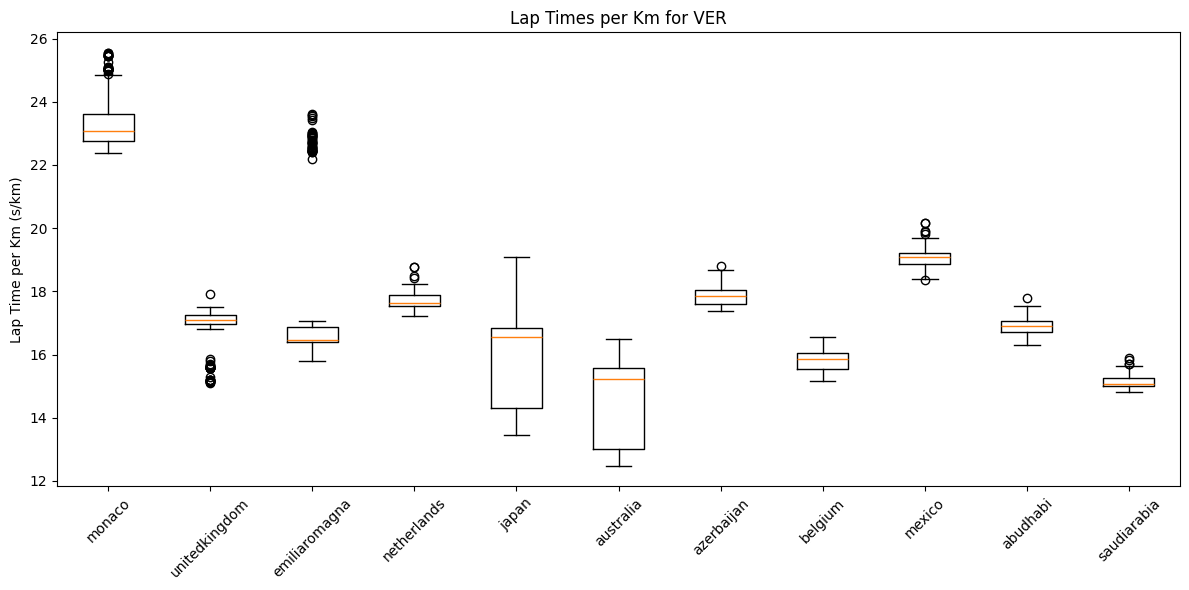


VER Statistical Analysis:
ANOVA F-statistic: 960.786858552534
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1690.2150109635513
Kruskal-Wallis p-value: 0.0
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



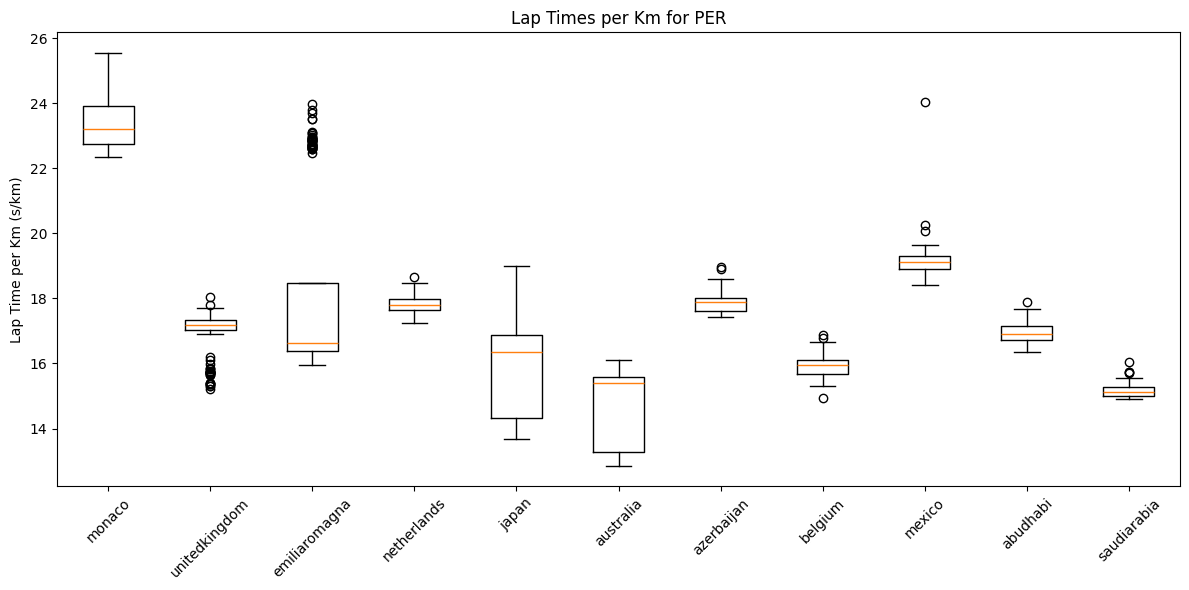


PER Statistical Analysis:
ANOVA F-statistic: 865.722246387186
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1558.7043647405858
Kruskal-Wallis p-value: 0.0
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



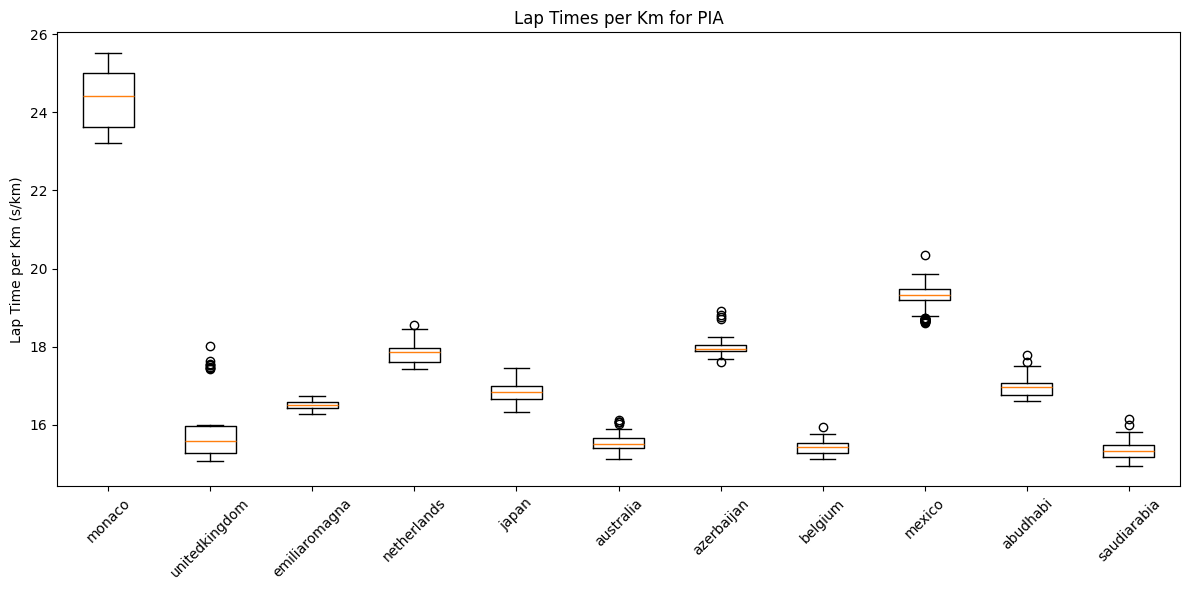


PIA Statistical Analysis:
ANOVA F-statistic: 4259.822667790866
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 903.2692686842258
Kruskal-Wallis p-value: 1.2599784309884103e-187
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



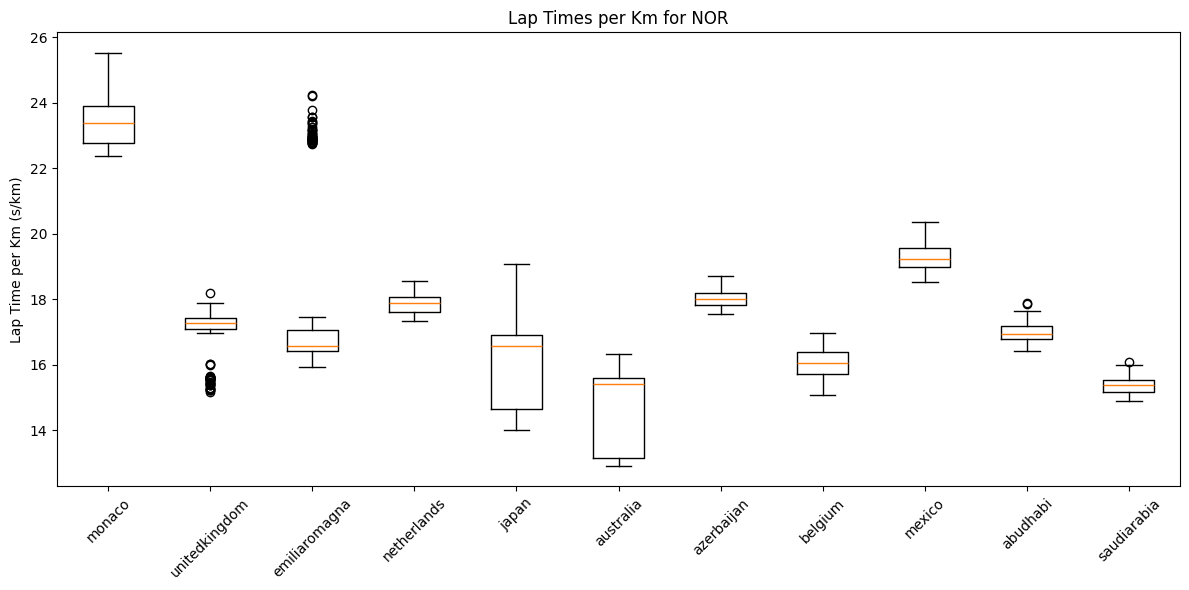


NOR Statistical Analysis:
ANOVA F-statistic: 935.2504837337317
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1719.9756272148993
Kruskal-Wallis p-value: 0.0
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



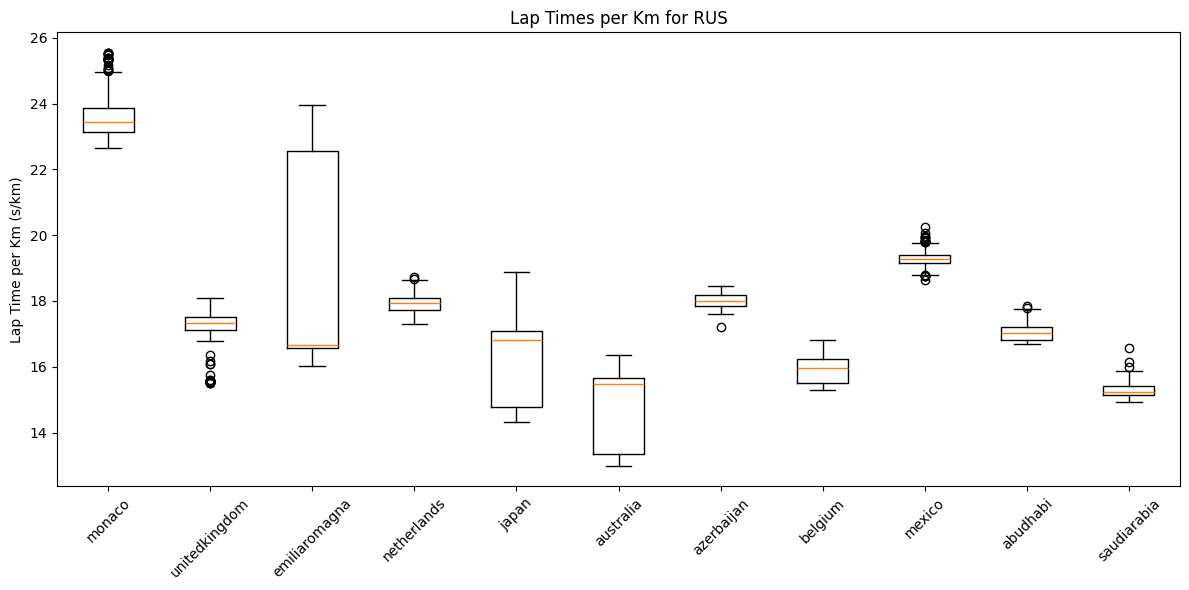


RUS Statistical Analysis:
ANOVA F-statistic: 1031.7951251224845
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1645.1696260177891
Kruskal-Wallis p-value: 0.0
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



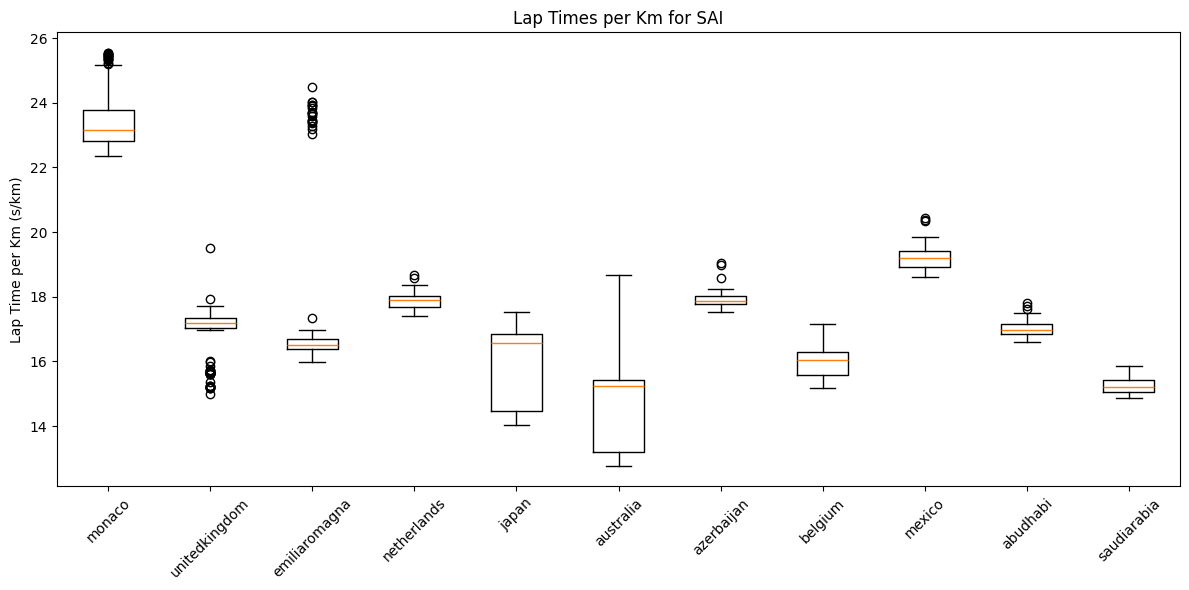


SAI Statistical Analysis:
ANOVA F-statistic: 1163.7746450677982
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1597.326226984446
Kruskal-Wallis p-value: 0.0
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



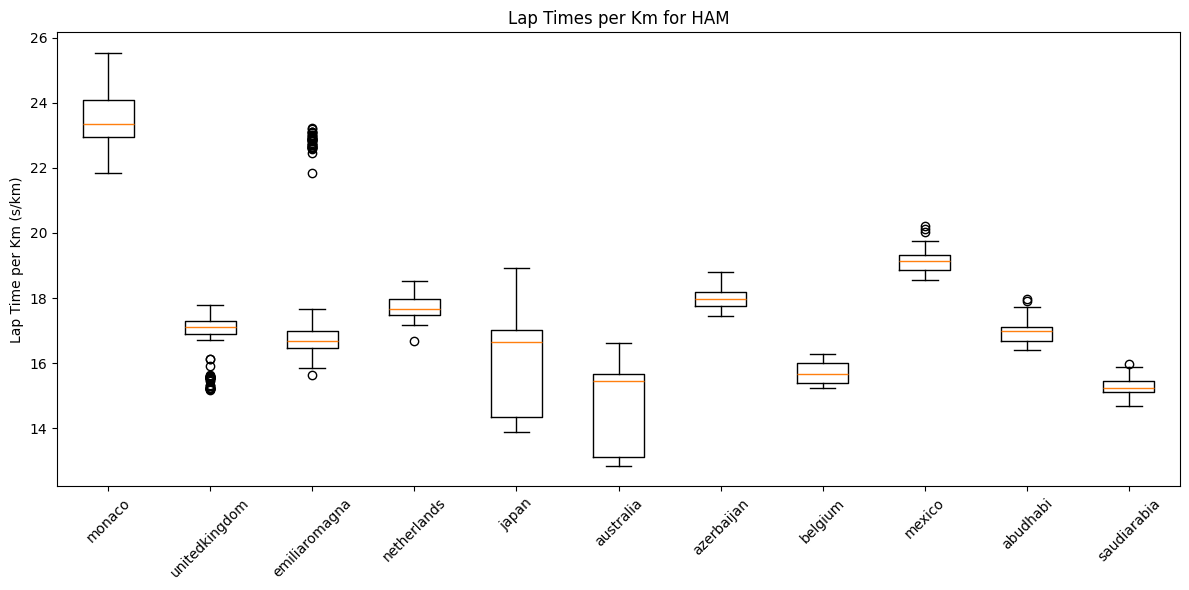


HAM Statistical Analysis:
ANOVA F-statistic: 1013.2467194372958
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1658.7704946955223
Kruskal-Wallis p-value: 0.0
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



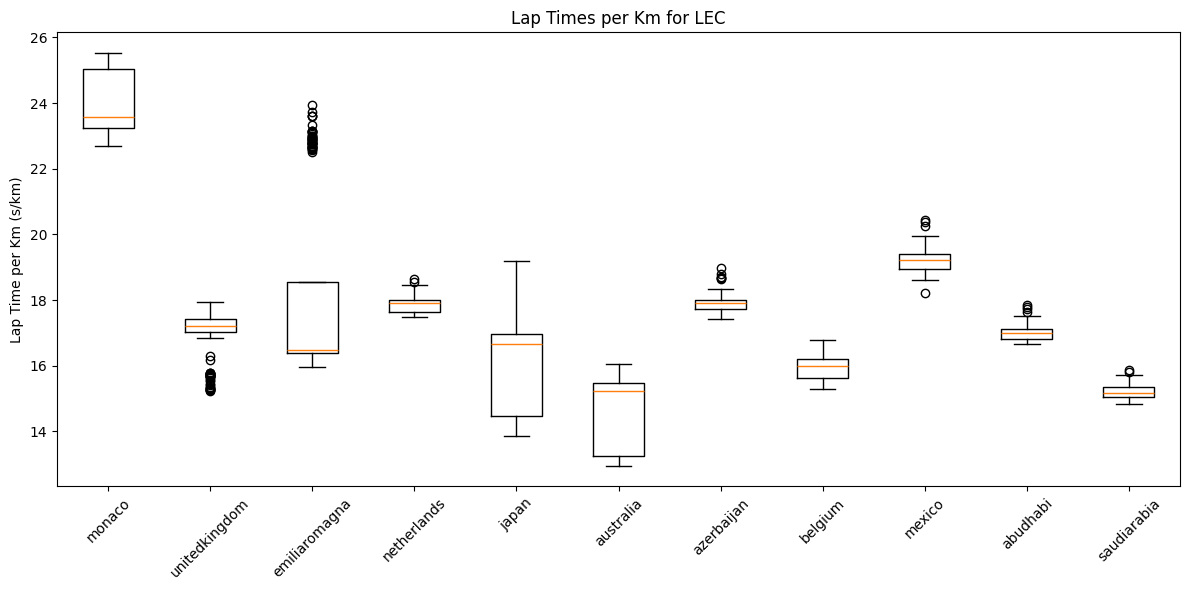


LEC Statistical Analysis:
ANOVA F-statistic: 799.7795603043684
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1589.4891918052685
Kruskal-Wallis p-value: 0.0
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



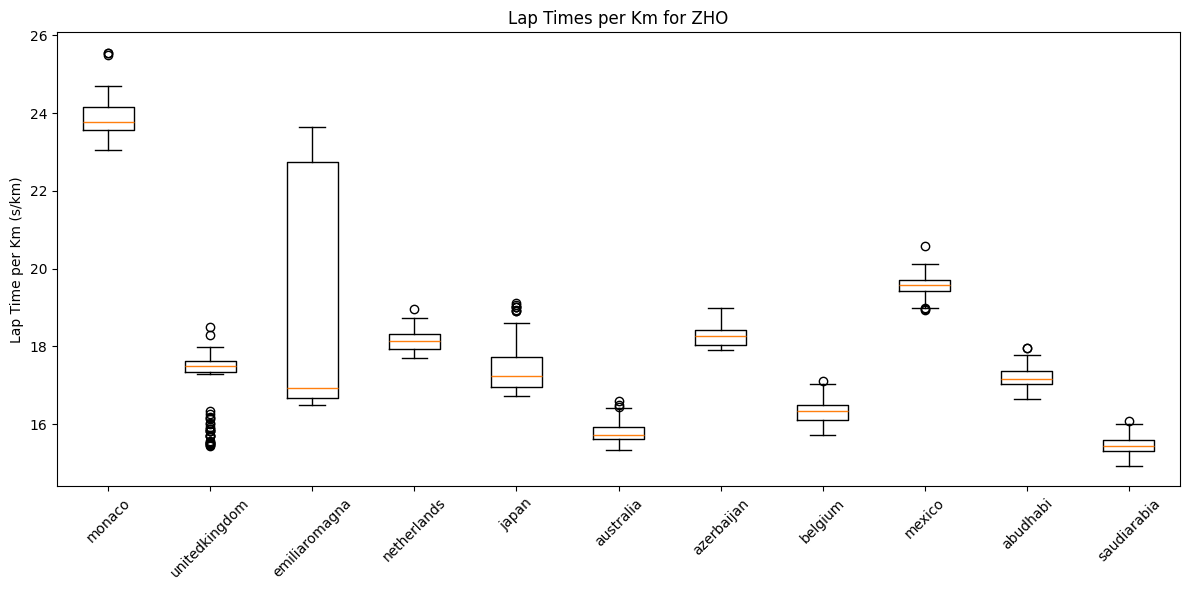


ZHO Statistical Analysis:
ANOVA F-statistic: 554.4776562256121
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1153.3044389733532
Kruskal-Wallis p-value: 1.6966234701139523e-241
Permutation p-value: 0.0


/var/folders/wl/yn_f16552qvcz999s7pwv5sm0000gn/T/ipykernel_5730/1058073606.py:52: DegenerateDataWarning:

at least one input has length 0



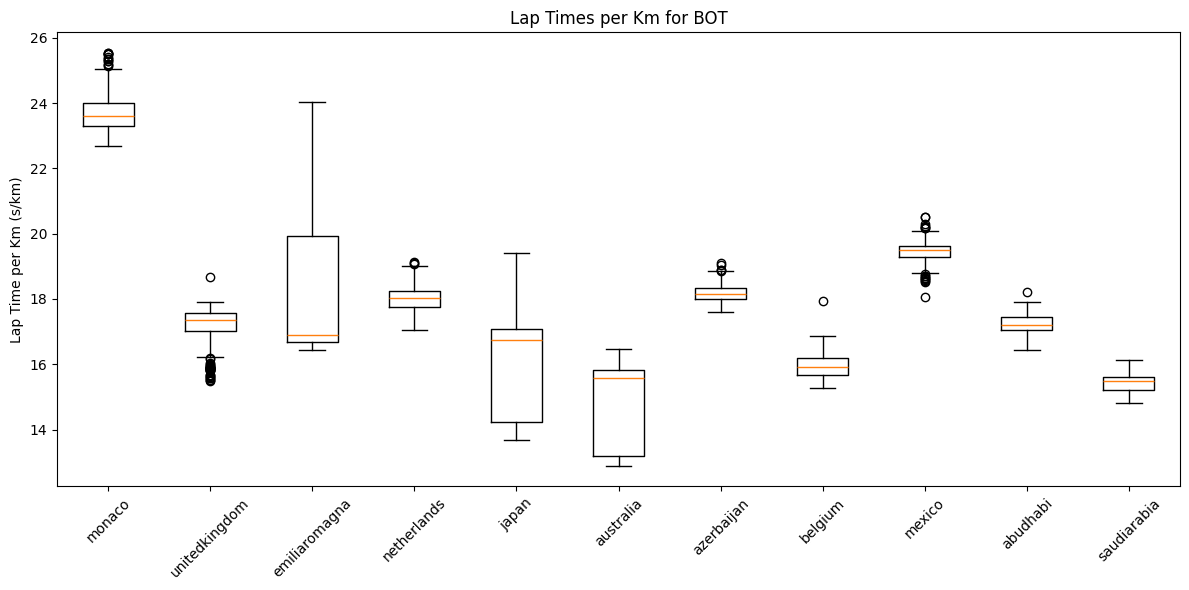


BOT Statistical Analysis:
ANOVA F-statistic: 691.5406884970783
ANOVA p-value: 0.0
Kruskal-Wallis H-statistic: 1458.2599312634306
Kruskal-Wallis p-value: 2.6077964074853253e-307
Permutation p-value: 0.0


In [98]:
def robust_statistical_analysis(df, drivers):
    analysis_results = []
    
    for driver in drivers:
        driver_data = df[df['Driver'] == driver]
        circuits = driver_data['Circuit'].unique()
        
        # Prepare groups for analysis
        lap_time_groups = []
        circuit_info = []
        
        for circuit in circuits:
            circuit_lap_times = driver_data[driver_data['Circuit'] == circuit]['LapTimePerKm'].values
            
            if len(circuit_lap_times) > 1:
                lap_time_groups.append(circuit_lap_times)
                circuit_info.append({
                    'circuit': circuit,
                    'mean': np.mean(circuit_lap_times),
                    'median': np.median(circuit_lap_times),
                    'std': np.std(circuit_lap_times),
                    'count': len(circuit_lap_times),
                    'min': np.min(circuit_lap_times),
                    'max': np.max(circuit_lap_times)
                })
        
        # Skip if insufficient groups
        if len(lap_time_groups) < 2:
            print(f"{driver}: Insufficient data for analysis")
            continue
        
        # Multiple statistical tests
        try:
            # 1. One-way ANOVA
            f_stat, anova_p = stats.f_oneway(*lap_time_groups)
            
            # 2. Kruskal-Wallis H-test (non-parametric)
            h_stat, kw_p = stats.kruskal(*lap_time_groups)
            
            # 3. Permutation test
            def permutation_test(groups, num_permutations=10000):
                # Combine all data
                combined = np.concatenate(groups)
                observed_f = stats.f_oneway(*groups)[0]
                
                # Permutation
                permuted_f_stats = []
                for _ in range(num_permutations):
                    # Shuffle and redistribute
                    np.random.shuffle(combined)
                    permuted_groups = np.split(combined, [len(g) for g in groups[:-1]])
                    permuted_f = stats.f_oneway(*permuted_groups)[0]
                    permuted_f_stats.append(permuted_f)
                
                # P-value as proportion of permuted F-stats >= observed
                p_value = np.mean([f >= observed_f for f in permuted_f_stats])
                return p_value
            
            perm_p = permutation_test(lap_time_groups)
            
            # Visualize circuit lap times
            plt.figure(figsize=(12, 6))
            plt.title(f'Lap Times per Km for {driver}')
            plt.boxplot(lap_time_groups, labels=[info['circuit'] for info in circuit_info])
            plt.ylabel('Lap Time per Km (s/km)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Prepare results
            result = {
                'Driver': driver,
                'Circuits': [info['circuit'] for info in circuit_info],
                'ANOVA F-statistic': f_stat,
                'ANOVA p-value': anova_p,
                'Kruskal-Wallis H-statistic': h_stat,
                'Kruskal-Wallis p-value': kw_p,
                'Permutation p-value': perm_p,
                'Circuit Details': circuit_info
            }
            
            analysis_results.append(result)
            
            # Print detailed results
            print(f"\n{driver} Statistical Analysis:")
            print(f"ANOVA F-statistic: {f_stat}")
            print(f"ANOVA p-value: {anova_p}")
            print(f"Kruskal-Wallis H-statistic: {h_stat}")
            print(f"Kruskal-Wallis p-value: {kw_p}")
            print(f"Permutation p-value: {perm_p}")
            
            # print("\nCircuit Performance:")
            # for info in circuit_info:
            #     print(f"{info['circuit']}:")
            #     print(f"  Mean: {info['mean']:.4f} s/km")
            #     print(f"  Median: {info['median']:.4f} s/km")
            #     print(f"  Std Dev: {info['std']:.4f}")
            #     print(f"  Laps: {info['count']}")
            
        except Exception as e:
            print(f"Analysis error for {driver}: {e}")
    
    return analysis_results

# Run the analysis
results = robust_statistical_analysis(df, drivers)

Mixed-Effects Model

In [112]:
# Multi-level model accounting for repeated measures
model = smf.mixedlm("LapTimePerKm ~ C(Circuit)",
                    data=df, 
                    groups=df["Driver"]) 

result = model.fit()
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     LapTimePerKm
No. Observations:      17913       Method:                 REML        
No. Groups:            10          Scale:                  1.0665      
Min. group size:       961         Log-Likelihood:         -26035.5982 
Max. group size:       2097        Converged:              Yes         
Mean group size:       1791.3                                          
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                   17.025    0.058 294.211 0.000 16.912 17.139
C(Circuit)[T.australia]     -2.201    0.035 -62.898 0.000 -2.270 -2.133
C(Circuit)[T.azerbaijan]     0.975    0.036  27.394 0.000  0.905  1.044
C(Circuit)[T.belgium]       -1.084    0.041 -26.455 0.000 -1.164 -1.003
C(Circuit

In [100]:
# # Set style and palette
# # plt.style.use('seaborn')
# palette = {'VER': '#0600EF',
#            'PER': '#0600EF',
#            'NOR': '#FF8700', 
#            'PIA': '#FF8700',
#            'RUS': '#00D2BE', 
#            'HAM': '#00D2BE', 
#            'SAI': '#DC0000', 
#            'LEC': '#DC0000',
#            'ZHO': '#C92D4B', 
#            'BOT': '#C92D4B', 
#            }  # Team colors

# # Create figure
# fig, ax = plt.subplots(figsize=(12, 8))

# # Create boxplot with enhanced parameters
# sns.boxplot(
#     x='Circuit', 
#     y='LapTimePerKm', 
#     hue='Driver', 
#     data=df, 
#     palette=palette,
#     linewidth=1.5,
#     fliersize=3,
#     width=0.7,
#     showmeans=True,
#     meanprops={
#         "markerfacecolor": "white",
#         "markeredgecolor": "black",
#         "markersize": "6"
#     }
# )

# # Add title and labels with improved formatting
# ax.set_title(
#     'Lap Time Performance Across Circuits (2021-2024)\nComparison of VER, NOR, RUS, and SAI',
#     fontsize=14,
#     pad=20,
#     fontweight='bold'
# )
# ax.set_ylabel('Lap Time per Km (s/km)', fontsize=12, labelpad=10)
# ax.set_xlabel('Grand Prix', fontsize=12, labelpad=10)  
# ax.set_xticklabels([gp_names.get(x.get_text(), x.get_text()) for x in ax.get_xticklabels()])

# # Rotate x-axis labels and adjust layout
# plt.xticks(rotation=45, ha='right', fontsize=10)
# plt.yticks(fontsize=10)

# # Add grid for better readability
# ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# # Improve legend
# plt.legend(
#     title='Driver',
#     title_fontsize=11,
#     fontsize=10,
#     bbox_to_anchor=(1.05, 1),
#     loc='upper left',
#     borderaxespad=0.
# )

# # # Add annotations for insights
# # plt.annotate(
# #     'Note: Lower lap times indicate better performance',
# #     xy=(0.5, -0.2),
# #     xycoords='axes fraction',
# #     ha='center',
# #     fontsize=10,
# #     color='gray'
# # )

# # Adjust layout and save
# plt.tight_layout()
# # plt.savefig('Lap Time Comparisons.png', dpi=300, bbox_inches='tight')
# plt.close()

In [101]:
drivers_to_graphs = ['ZHO', 'BOT', 'SAI']
driver_str = ", ".join(drivers_to_graphs)
fig = go.Figure()

for driver in drivers_to_graphs:
    fig.add_trace(go.Box(
        y=df[df['Driver'] == f"{driver}"]['LapTimePerKm'].values,
        x=df[df['Driver'] == f"{driver}"]['Circuit'].map(gp_names),
        name=f"{driver}",
        marker_color=palette.get(driver),
        # boxpoints='all',
        jitter=0.5,
        # whiskerwidth=0.2,
        marker_size=2,
        line_width=1
    ))

fig.update_layout(
    title_text=f"Lap Time Performance Across Circuits (2021-2024)\nComparison of {driver_str}",
    yaxis=dict(
        title=dict(
            text='Lap Time per Km (s/km)')
    ),
    boxmode='group' # group together boxes of the different traces for each value of x
)

fig.show()

In [104]:
drivers_to_graphs = ['VER', 'PER', 'LEC','SAI', 'NOR', 'PIA','HAM', 'RUS']
driver_str = ", ".join(drivers_to_graphs)

def create_subplot_boxplots(df):
    unique_circuits = df['Circuit'].unique()
    rows = (len(unique_circuits) + 1) // 2  # Calculate number of rows needed
    
    fig = make_subplots(
        rows=rows, 
        cols=2, 
        subplot_titles=[gp_names.get(circuit, circuit) for circuit in unique_circuits]
    )
    
    for i, circuit in enumerate(unique_circuits):
        row = i // 2 + 1
        col = i % 2 + 1
        
        for driver in drivers_to_graphs:
            circuit_driver_data = df[(df['Circuit'] == circuit) & (df['Driver'] == driver)]
            
            fig.add_trace(
                go.Box(
                    y=circuit_driver_data['LapTimePerKm'].values,
                    name=driver,
                    marker_color=palette.get(driver),
                    boxpoints='all',
                    jitter=0.3,
                    whiskerwidth=0.2,
                    marker_size=2,
                    line_width=1
                ),
                row=row, 
                col=col
            )
        
    fig.update_layout(
        height=300 * rows,  # Adjust height based on number of rows
        title_text=f"Lap Time Performance Across Circuits (2021-2024)\nComparison of {driver_str}",
        showlegend=False
    )
    
    fig.update_yaxes(title_text='Lap Time per Km (s/km)', 
                     title_font = dict(
                         size = 10
                     ))
    
    return fig

x = create_subplot_boxplots(df)
x.show()
x.write_image(f"Lap Performance Across 2021-2024 - {driver_str}.png", scale=6, width=1000, height=1600)

In [103]:
def create_dropdown_boxplot(df):
    fig = go.Figure()
    
    unique_circuits = df['Circuit'].unique()
    
    # Tracks which traces belong to which circuit
    circuit_trace_indices = {circuit: [] for circuit in unique_circuits}
    
    for driver in ['VER', 'NOR', 'RUS', 'SAI']:
        for circuit in unique_circuits:
            circuit_driver_data = df[(df['Circuit'] == circuit) & (df['Driver'] == driver)]
            
            trace = go.Box(
                y=circuit_driver_data['LapTimePerKm'].values,
                x=[gp_names.get(circuit, circuit)] * len(circuit_driver_data),
                name=driver,
                marker_color=palette.get(driver),
                visible=(circuit == unique_circuits[0]),
                # boxpoints='all',
                # jitter=0.3,
                # whiskerwidth=0.2,
                # marker_size=2,
                # line_width=1  
            )
            
            fig.add_trace(trace)
            circuit_trace_indices[circuit].append(len(fig.data) - 1)
    
    # Create dropdown menu
    dropdown_buttons = []
    for circuit in unique_circuits:
        visibility = [False] * len(fig.data)
        for idx in circuit_trace_indices[circuit]:
            visibility[idx] = True
        
        dropdown_buttons.append(dict(
            method='update',
            label=gp_names.get(circuit, circuit),
            args=[{'visible': visibility}, 
                  {'title': f'Lap Times for {gp_names.get(circuit, circuit)}'}]
        ))
    
    fig.update_layout(
        updatemenus=[{
            'buttons': dropdown_buttons,
            'direction': 'down',
            'showactive': True,
        }],
        yaxis_title='Lap Time per Km (s/km)',
        title=f'Lap Times for {gp_names.get(unique_circuits[0], unique_circuits[0])}',
        boxmode='group'
    )
    
    return fig

# Create and show the figure
fig = create_dropdown_boxplot(df)
fig.show()